In [2]:
!~/new_python_3_11_env/bin/python3 -m pip install tensorflow-datasets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 59.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.4/165.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 62.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.7/221.7 kB 8.6 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21483 sha256=ed36673593f7058df1190b258aef1595ea0d937150af0243bdf3997fe78150d1
  Stored in directory: /home/jovyan/.cache/pip/wheels/90/74/b1/9b54c896b8d9409e9268329d4d45ede8a8040abe91c8879932
Successfully built promise

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: /ho

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np

2025-01-07 11:20:23.484494: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 11:20:23.557021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736245223.576451     297 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736245223.581648     297 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 11:20:23.600009: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Load original model
original_model = tf.keras.models.load_model('dej_cnn_mnist_model.keras')  # Replace with your model file
original_model.trainable = False  # Freeze weights


W0000 00:00:1736245249.773576     297 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/jovyan/new_python_3_11_env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
# Define ATN
def build_atn(input_shape):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(np.prod(input_shape), activation='sigmoid'),  # Use sigmoid for range [0, 1]
        layers.Reshape(input_shape),
        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]
    ])
    return model


input_shape = (28, 28, 1)  # Assuming MNIST dataset
atn = build_atn(input_shape)


/home/jovyan/new_python_3_11_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Define input loss and output loss function
def input_loss(x, x_prime):
    return tf.reduce_mean(tf.square(tf.cast(x, tf.float32) - x_prime))  # Cast x to float32  # L2 loss

def output_loss(y_pred, y_target):
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_target, y_pred)) # crossentropy



In [11]:
# Combine the models
input_img = tf.keras.Input(shape=input_shape)
x_prime = atn(input_img)
y_pred = original_model(x_prime)

combined_model = tf.keras.Model(inputs=input_img, outputs=[x_prime, y_pred])


In [12]:
# Define training procedure
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
beta = 0.1  # Weight for input-space loss

@tf.function
def train_step(x, y_target):
    with tf.GradientTape() as tape:
        x_prime, y_pred = combined_model(x)
        loss = beta * input_loss(x, x_prime) + output_loss(y_pred, y_target)
    gradients = tape.gradient(loss, atn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, atn.trainable_variables))
    return loss


In [13]:
# Load MNIST dataset
mnist_train, mnist_test = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

# Function to create adversarial target labels
def create_adversarial_target(label):
    # Example: Shift each label by 1 (cyclic mapping)
    return (label + 1) % 10

# Preprocessing function for training the ATN
def preprocess_image_atn(image, label):
    # Normalize images to [0, 1]
    image = image
    label_one_hot = tf.one_hot(label, depth=10)  # One-hot encode the original label
    
    # Generate adversarial target labels
    adversarial_target = create_adversarial_target(label)
    adversarial_target_one_hot = tf.one_hot(adversarial_target, depth=10)
    
    return image, label_one_hot, adversarial_target_one_hot

# Apply preprocessing
mnist_train_atn = mnist_train.map(preprocess_image_atn)
mnist_test_atn = mnist_test.map(preprocess_image_atn)

# Batch the dataset
batch_size = 32
mnist_train_atn = mnist_train_atn.batch(batch_size).prefetch(tf.data.AUTOTUNE)
mnist_test_atn = mnist_test_atn.batch(batch_size).prefetch(tf.data.AUTOTUNE)
print("loaded dataset")

loaded dataset


In [14]:
# Training loop
epochs = 50
batch_size = 32
beta = 0.1  # Weight for the input-space loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for epoch in range(epochs):
    epoch_loss = 0
    batch_count = 0

    for x_batch, _, y_target_batch in mnist_train_atn:  # Use only x (images) and y_target (adversarial labels)
        loss = train_step(x_batch, y_target_batch)
        epoch_loss += loss.numpy()
        batch_count += 1

    avg_loss = epoch_loss / batch_count
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

2025-01-07 11:22:36.104829: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/50, Loss: 81.4104


2025-01-07 11:23:20.351267: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/50, Loss: 53.0784
Epoch 3/50, Loss: 47.9304


2025-01-07 11:24:51.029434: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/50, Loss: 45.5010
Epoch 5/50, Loss: 44.0393


KeyboardInterrupt: 

In [49]:
# Save the ATN in the newer `.keras` format for future compatibility
atn.save('adversarial_transformation_network.keras')
print("ATN saved successfully.")


ATN saved successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


2025-01-06 19:07:26.119508: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
True Labels: [2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3]
Original Predictions: [2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3]
Transformed Predictions: [2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3]


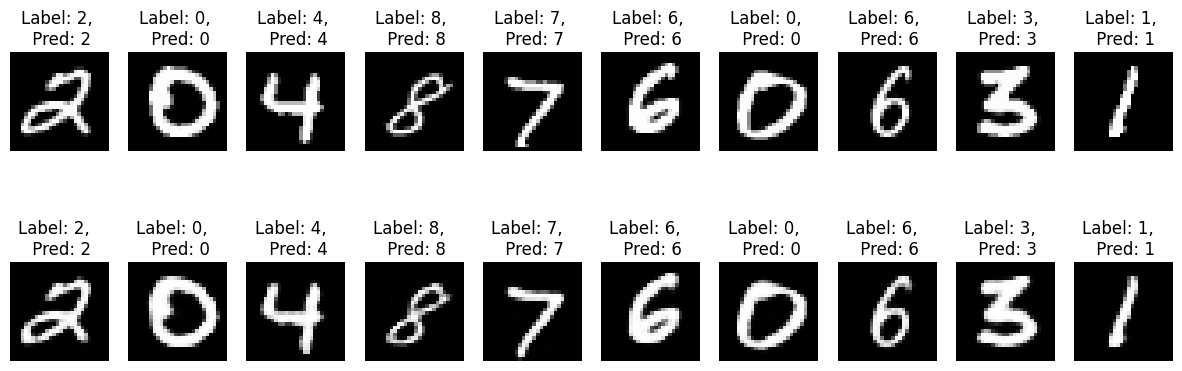

In [50]:
import matplotlib.pyplot as plt

# Function to evaluate and compare results
def evaluate_atn(original_model, atn, dataset):
    for x_batch, y_original_batch, y_target_batch in dataset.take(1):  # Take one batch for simplicity
        # Generate transformed images
        x_transformed = atn.predict(x_batch)
        
        # Get predictions for both original and transformed images
        y_pred_original = tf.argmax(original_model.predict(x_batch), axis=1)
        y_pred_transformed = tf.argmax(original_model.predict(x_transformed), axis=1)
        
        # Get true labels
        y_true = tf.argmax(y_original_batch, axis=1)
        
        # Print results for comparison
        print("True Labels:", y_true.numpy())
        print("Original Predictions:", y_pred_original.numpy())
        print("Transformed Predictions:", y_pred_transformed.numpy())
        
        # Display images
        display_images(x_batch, x_transformed, y_true, y_pred_original, y_pred_transformed)
        break  # Only evaluate one batch for now

# Function to display images
def display_images(original_images, transformed_images, y_true, y_pred_original, y_pred_transformed):
    num_images = min(10, len(original_images))  # Display up to 10 images
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(tf.squeeze(original_images[i]), cmap='gray')  # Remove channel for grayscale display
        plt.title(f"Label: {y_true[i].numpy()}, \n Pred: {y_pred_original[i].numpy()}")
        plt.axis('off')
        
        # Transformed image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(tf.squeeze(transformed_images[i]), cmap='gray')
        plt.title(f"Label: {y_true[i].numpy()},  \n Pred: {y_pred_transformed[i].numpy()}")
        plt.axis('off')
    
    plt.show()

# Evaluate the ATN on the test dataset
evaluate_atn(original_model, atn, mnist_test_atn)


In [51]:
# Function to calculate accuracy
def calculate_accuracy(model, dataset, atn=None):
    correct = 0
    total = 0
    
    for x_batch, y_original_batch, _ in dataset:
        if atn:
            x_batch = atn.predict(x_batch, verbose=0)  # Transform images if ATN is provided
        y_pred = tf.argmax(model.predict(x_batch, verbose=0), axis=1)  # Suppress progress output
        y_true = tf.argmax(y_original_batch, axis=1)
        correct += tf.reduce_sum(tf.cast(y_pred == y_true, tf.float32)).numpy()
        total += x_batch.shape[0]
    
    return correct / total

# Original accuracy
original_accuracy = calculate_accuracy(original_model, mnist_test_atn, atn=None)
print(f"Accuracy on original images: {original_accuracy:.4f}")

# Transformed accuracy
transformed_accuracy = calculate_accuracy(original_model, mnist_test_atn, atn=atn)
print(f"Accuracy on transformed images: {transformed_accuracy:.4f}")


Accuracy on original images: 0.9842
Accuracy on transformed images: 0.9824
